In [183]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
import tqdm

In [153]:
header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

In [154]:
races_dict = {
    "msr":"https://www.procyclingstats.com/race/milano-sanremo/2022",
    }

In [176]:
stages = range(1,22) # 22
years = range(1990,2022)
stages_dict = {}

for year in years:
    for stage in stages:
        stage_name = f"tdf_{stage}_{year}"
        url = f"https://www.procyclingstats.com/race/tour-de-france/{year}/stage-{stage}"
        stages_dict[stage_name] = url

print(len(stages_dict))

672


In [186]:
def get_data(races_dict: dict) -> dict:
    data_list = []
    error_log = dict()
    print("Getting...")
    for race in tqdm.tqdm(races_dict, desc="Progress bar on fetching stages data", unit="stage"):
        try:
            #print(f"{race}")
            time.sleep(1)
            url = races_dict[race]
            page = requests.get(url, headers=header)
            soup = BeautifulSoup(page.content, 'html.parser')
            data = soup.find('ul',{'class':'infolist'}).get_text().strip().split('\n')
            data_dict = {point.split(': ')[0].strip():point.split(': ')[1].strip() for point in data}
            data_dict['Race'] = race
            yield data_dict
            
        except AttributeError as e:
            error_log[race] = e

In [187]:
data_list = [pd.DataFrame(data, index=[0]) for data in get_data(stages_dict)]

Getting...


Progress bar on fetching stages data::  12%|█████                                   | 84/672 [05:53<50:20,  5.14s/stage]

'NoneType' object has no attribute 'get_text'
Issue with stage tdf_21_1993


Progress bar on fetching stages data::  19%|███████▎                               | 126/672 [08:23<31:17,  3.44s/stage]

'NoneType' object has no attribute 'get_text'
Issue with stage tdf_21_1995


Progress bar on fetching stages data::  28%|██████████▋                            | 185/672 [12:04<29:03,  3.58s/stage]

'NoneType' object has no attribute 'get_text'
Issue with stage tdf_17_1998


Progress bar on fetching stages data::  31%|████████████▏                          | 210/672 [13:40<32:01,  4.16s/stage]

'NoneType' object has no attribute 'get_text'
Issue with stage tdf_21_1999


Progress bar on fetching stages data::  38%|██████████████▋                        | 252/672 [16:21<26:57,  3.85s/stage]

'NoneType' object has no attribute 'get_text'
Issue with stage tdf_21_2001


Progress bar on fetching stages data::  41%|███████████████▊                       | 273/672 [17:41<24:46,  3.73s/stage]

'NoneType' object has no attribute 'get_text'
Issue with stage tdf_21_2002


Progress bar on fetching stages data::  44%|█████████████████                      | 294/672 [19:00<22:31,  3.58s/stage]

'NoneType' object has no attribute 'get_text'
Issue with stage tdf_21_2003


Progress bar on fetching stages data::  47%|██████████████████▎                    | 315/672 [20:19<22:05,  3.71s/stage]

'NoneType' object has no attribute 'get_text'
Issue with stage tdf_21_2004


Progress bar on fetching stages data::  53%|████████████████████▋                  | 357/672 [22:56<18:55,  3.60s/stage]

'NoneType' object has no attribute 'get_text'
Issue with stage tdf_21_2006


Progress bar on fetching stages data::  56%|█████████████████████▉                 | 378/672 [24:15<18:02,  3.68s/stage]

'NoneType' object has no attribute 'get_text'
Issue with stage tdf_21_2007


Progress bar on fetching stages data::  66%|█████████████████████████▌             | 441/672 [28:14<14:05,  3.66s/stage]

'NoneType' object has no attribute 'get_text'
Issue with stage tdf_21_2010


Progress bar on fetching stages data::  72%|████████████████████████████           | 483/672 [30:56<11:32,  3.66s/stage]

'NoneType' object has no attribute 'get_text'
Issue with stage tdf_21_2012


Progress bar on fetching stages data:: 100%|███████████████████████████████████████| 672/672 [42:57<00:00,  3.84s/stage]


In [263]:
df = pd.concat(data_list).reset_index(drop=True)

df.columns = ['date','start_time','avg_speed','race_category','distance','points_scale',
              'parcour_type','profile_score','elevation','departure','arrival','race_ranking',
              'startlist_quality_score','won_how','race']

distance = df.distance.str.split(' ',expand=True)
avg_speed = df.avg_speed.str.split(' ',expand=True)

df.distance = distance[0]
df['distance_units'] = distance[1]

df.avg_speed = avg_speed[0]
df['avg_speed_units'] = avg_speed[1]

df.date = pd.to_datetime(df.date).dt.date
df['year'] = pd.to_datetime(df.date).dt.year

df.distance = pd.to_numeric(df.distance)
df.elevation = pd.to_numeric(df.elevation)

#df['year'] = df.date.dt.year

In [264]:
df

,date,start_time,avg_speed,race_category,distance,points_scale,parcour_type,profile_score,elevation,departure,arrival,race_ranking,startlist_quality_score,won_how,race,distance_units,avg_speed_units,year
0,1990-07-01,-,41.76,ME - Men Elite,138.5,GT.A.Stage,,,NaN,Futuroscope,Futuroscope,249,0,? - let us know!,tdf_1_1990,km,km/h,1990
1,1990-07-01,-,50,ME - Men Elite,44.5,GT.A.TTT,,,NaN,Futuroscope,Futuroscope,249,0,Time Trial,tdf_2_1990,km,km/h,1990
2,1990-07-02,-,40.38,ME - Men Elite,233.0,GT.A.Stage,,,NaN,Poitiers,Nantes,249,0,? - let us know!,tdf_3_1990,km,km/h,1990
3,1990-07-03,-,37.64,ME - Men Elite,203.0,GT.A.Stage,,,NaN,Nantes,Mont-Saint-Michel,249,0,? - let us know!,tdf_4_1990,km,km/h,1990
4,1990-07-04,-,39,ME - Men Elite,301.0,GT.A.Stage,,,NaN,Avranches,Rouen,249,0,? - let us know!,tdf_5_1990,km,km/h,1990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,2021-07-14,12:10,35.267,ME - Men Elite,178.4,GT.A.Stage,,450,4375.0,Muret,Saint-Lary-Soulan (Col du Portet),1,1646,Sprint of small group,tdf_17_2021,km,km/h,2021
656,2021-07-15,13:50,36.407,ME - Men Elite,129.7,GT.A.Stage,,367,3561.0,Pau,Luz Ardiden,1,1646,0.6 km solo,tdf_18_2021,km,km/h,2021
657,2021-07-16,12:30,47.901,ME - Men Elite,207.0,GT.A.Stage,,16,1181.0,Mourenx,Libourne,1,1646,26 km solo,tdf_19_2021,km,km/h,2021
658,2021-07-17,13:05,51.5,ME - Men Elite,30.8,GT.A.Stage,,8,246.0,Libourne,Saint-Émilion,1,1646,Time Trial,tdf_20_2021,km,km/h,2021


In [265]:
df_test = df[['year','distance','elevation']]

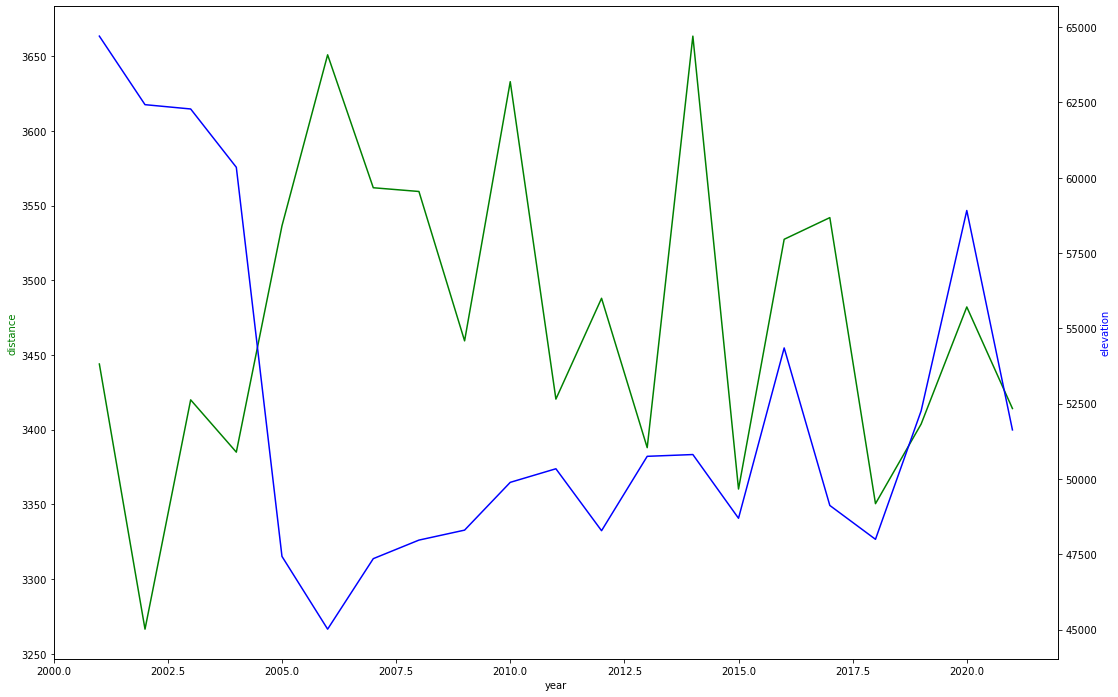

In [280]:
for_plot = df_test.groupby(by='year').sum()
plot_range = for_plot.index > 2000
for_plot = for_plot.loc[plot_range]

fig, ax1 = plt.subplots(figsize=(18, 12))

ax2 = ax1.twinx()
ax1.plot(for_plot.index, for_plot.distance, 'g-')
ax2.plot(for_plot.index, for_plot.elevation, 'b-')

ax1.set_xlabel('year')
ax1.set_ylabel('distance', color='g')
ax2.set_ylabel('elevation', color='b')

plt.show()